# Step 3 — Exhaustive Feature Engineering
Feature group 조합을 평가하여 best feature subset을 찾는 단계.
총 64개 subset을 LightGBM mini model로 테스트하고 score + vol_ratio를 계산한다.

=== Final Training & Backtest Start ===
Total rows after dropna: 9021
Using 22 features:
['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
Train size: 7217
Test size:  1804
Training LightGBM model...
Model training complete.
Target mean=0.000015, std=0.010413

=== FINAL BACKTEST METRICS ===
Strategy Cumulative Return: 2.7420
Market   Cumulative Return: 2.7309
Sharpe-like:  0.0457
Vol Ratio:    1.0277
MaxDD Strat:  -0.2900
MaxDD Market: -0.2413


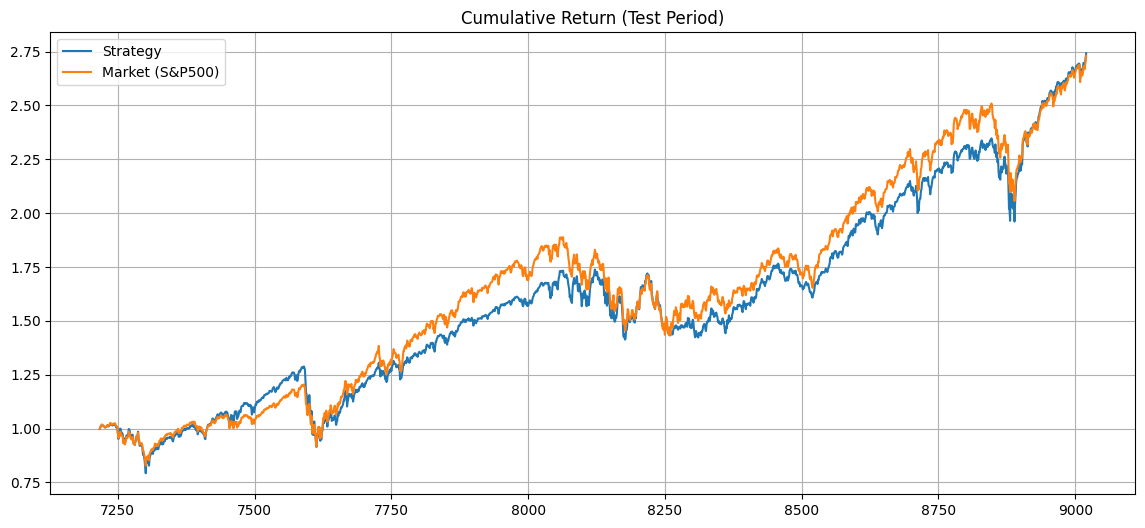

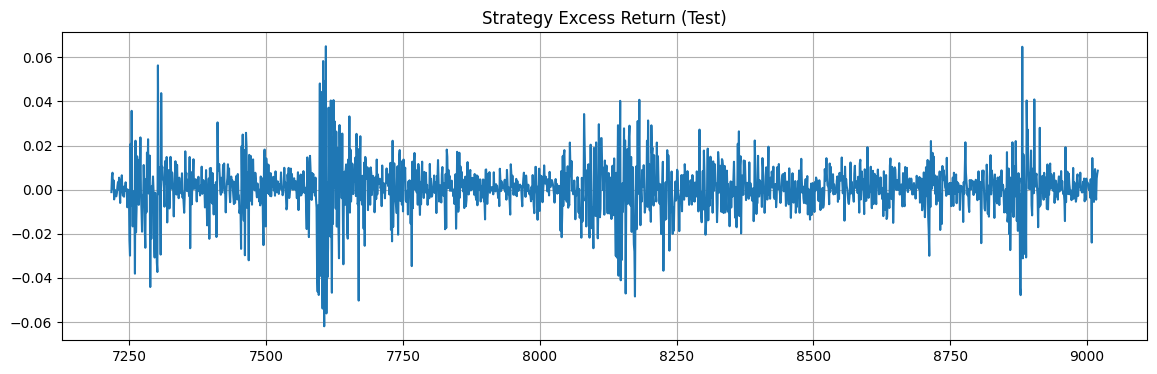

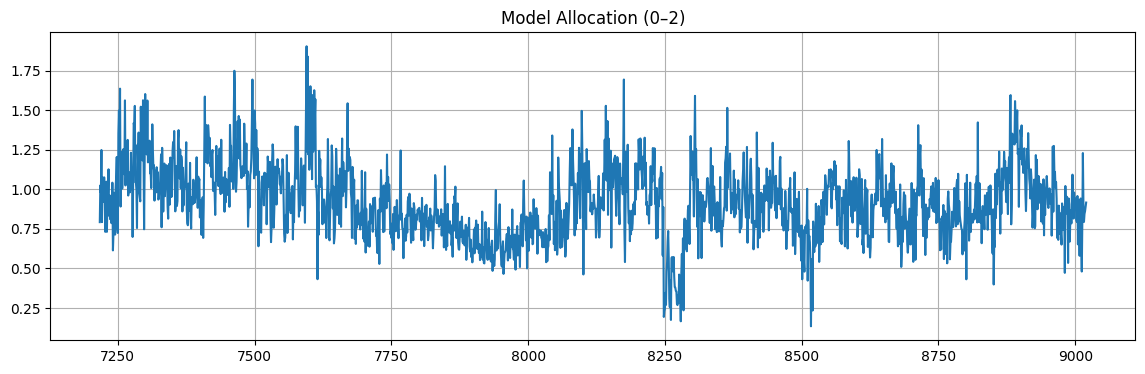

=== Finished ===


In [1]:
# ============================================================
# FINAL TRAINING + BACKTEST NOTEBOOK CODE
# Hull Tactical Market Prediction
# Features: Interest (I*) + Valuation (P*)
# Model: LightGBM Regression + allocation(0~2)
# ============================================================

import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# -----------------------------
# 0. Load dataset
# -----------------------------
TRAIN_PATH = "/kaggle/input/hull-tactical-market-prediction/train.csv"
TARGET_NAME = "market_forward_excess_returns"

print("=== Final Training & Backtest Start ===")

if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError("train.csv not found.")

df = pd.read_csv(TRAIN_PATH).sort_values("date_id")

# 타깃/기본 열 NaN 제거
df = df.dropna(subset=[
    TARGET_NAME, 
    "forward_returns", 
    "risk_free_rate", 
    "market_forward_excess_returns"
])

print(f"Total rows after dropna: {len(df)}")

# -----------------------------
# 1. Feature selection (I* + P*)
# -----------------------------
all_cols = df.columns.tolist()

interest_cols  = [c for c in all_cols if c.startswith("I")]
valuation_cols = [c for c in all_cols if c.startswith("P")]

feature_cols = sorted(interest_cols + valuation_cols)

print(f"Using {len(feature_cols)} features:")
print(feature_cols)

X_all = df[feature_cols].fillna(0.0).values
y_all = df[TARGET_NAME].values

# -----------------------------
# 2. Time-series train/test split
# -----------------------------
unique_dates = np.sort(df["date_id"].unique())
n_dates = len(unique_dates)

n_test = max(180, int(0.2 * n_dates))   # 최소 180일 test
test_dates = unique_dates[-n_test:]
train_dates = unique_dates[:-n_test]

train_mask = df["date_id"].isin(train_dates)
test_mask  = df["date_id"].isin(test_dates)

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

df_train = df[train_mask].copy()
df_test  = df[test_mask].copy()

print(f"Train size: {X_train.shape[0]}")
print(f"Test size:  {X_test.shape[0]}")

# -----------------------------
# 3. LightGBM Training
# -----------------------------
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.02,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "verbosity": -1,
}

dtrain = lgb.Dataset(X_train, label=y_train)

print("Training LightGBM model...")
model = lgb.train(params, dtrain, num_boost_round=1200)
print("Model training complete.")

y_mean = float(y_train.mean())
y_std  = float(y_train.std() + 1e-9)

print(f"Target mean={y_mean:.6f}, std={y_std:.6f}")

# -----------------------------
# 4. Predict + Allocation(0~2)
# -----------------------------
def pred_to_allocation(y_pred, mean, std, alpha=0.5):
    z = (y_pred - mean) / (std + 1e-9)
    w = 1.0 + alpha * z
    return np.clip(w, 0.0, 2.0)

y_pred_test = model.predict(X_test)
alloc = pred_to_allocation(y_pred_test, y_mean, y_std, alpha=0.5)

df_test["model_alloc"] = alloc

# -----------------------------
# 5. Backtest metrics
# -----------------------------
fwd  = df_test["forward_returns"].values
rf   = df_test["risk_free_rate"].values
mkt_excess = df_test["market_forward_excess_returns"].values

strategy_ret    = alloc * fwd
strategy_excess = strategy_ret - rf

df_test["strategy_ret"]    = strategy_ret
df_test["strategy_excess"] = strategy_excess

df_test["cum_strategy"] = (1 + df_test["strategy_ret"]).cumprod()
df_test["cum_market"]   = (1 + fwd).cumprod()

vol_s = strategy_excess.std()
vol_m = mkt_excess.std() + 1e-9

mu_s = strategy_excess.mean()
mu_m = mkt_excess.mean()

sharpe_s = mu_s / (vol_s + 1e-9)
vol_ratio = vol_s / vol_m

def max_drawdown(series):
    running_max = series.cummax()
    dd = (series - running_max) / running_max
    return dd.min()

mdd_strategy = max_drawdown(df_test["cum_strategy"])
mdd_market   = max_drawdown(df_test["cum_market"])

print("\n=== FINAL BACKTEST METRICS ===")
print(f"Strategy Cumulative Return: {df_test['cum_strategy'].iloc[-1]:.4f}")
print(f"Market   Cumulative Return: {df_test['cum_market'].iloc[-1]:.4f}")
print(f"Sharpe-like:  {sharpe_s:.4f}")
print(f"Vol Ratio:    {vol_ratio:.4f}")
print(f"MaxDD Strat:  {mdd_strategy:.4f}")
print(f"MaxDD Market: {mdd_market:.4f}")

# -----------------------------
# 6. Graphs (for report)
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(df_test["date_id"], df_test["cum_strategy"], label="Strategy")
plt.plot(df_test["date_id"], df_test["cum_market"], label="Market (S&P500)")
plt.title("Cumulative Return (Test Period)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df_test["date_id"], df_test["strategy_excess"], label="Strategy Excess Return")
plt.title("Strategy Excess Return (Test)")
plt.grid()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df_test["date_id"], df_test["model_alloc"], label="Allocation (0–2)")
plt.title("Model Allocation (0–2)")
plt.grid()
plt.show()

print("=== Finished ===")